In [1]:
import time

In [2]:
from random import uniform

import numpy as np
from multivariate_util import *

In [3]:
import copy

In [4]:
from matplotlib.animation import FuncAnimation, ArtistAnimation
import matplotlib.pyplot as plt

In [5]:
size = 300

actual_mu01  = [-4, .4]
actual_cov01 = [[.40, 0], [.7, 1.55]]
actual_df01  = 27
x01 = multivariate_t_rvs(m=actual_mu01, S=actual_cov01, df=actual_df01, n=size)

actual_mu02  = [.9, -.5]
actual_cov02 = [[1.5, 0.7], [0, 0.5]]
actual_df02  = 47
x02 = multivariate_t_rvs(m=actual_mu02, S=actual_cov02, df=actual_df02, n=size)

x01 = np.concatenate([x01, x02])

In [6]:
actual_t01 = multivariate_t(actual_mu01, actual_cov01, actual_df01)
actual_t02 = multivariate_t(actual_mu02, actual_cov02, actual_df02)

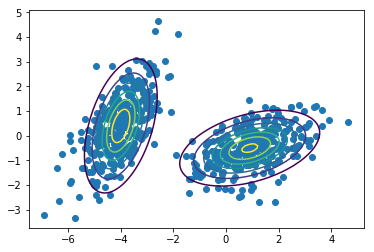

In [7]:
xmin, xmax = min(x01.T[0]), max(x01.T[0])
ymin, ymax = min(x01.T[1]), max(x01.T[1])

x, y = np.mgrid[xmin:xmax:.1, ymin:ymax:.1]
xy   = np.column_stack([x.ravel(), y.ravel()])

plt.scatter(x01.T[0], x01.T[1])
plt.contour(x, y, np.reshape(actual_t01.pdf(xy), x.shape))
plt.contour(x, y, np.reshape(actual_t02.pdf(xy), x.shape))

plt.show()

In [8]:
t = MultivariateTMixture(2)

In [9]:
t.fit(x01)

In [10]:
start = time.time()
l = []

best = t;
likelihood = t.log_likelihood(x01)
l.append(likelihood)

for j in range(1):
    t = MultivariateTMixture(2)
    t.fit(x01)
    for i in range(60):
        t.iterate(x01)

        if t.log_likelihood(x01) > likelihood:
            best = copy.deepcopy(t)
            likelihood = t.log_likelihood(x01)
        
        l.append(t.log_likelihood(x01))

print 'elapsed time %s' % (time.time() - start)
print t.mixes
print t.pi
print 'LIKELIHOOD %.8f' % likelihood

elapsed time 3.03999996185
[mu: [-4.05140996  0.40680192];
 df: 30.71;
 sigma: [[ 0.61603451  0.60740393]
 [ 0.60740393  1.53267646]], mu: [ 0.93109816 -0.46240794];
 df: 37.68;
 sigma: [[ 1.23188877  0.41376391]
 [ 0.41376391  0.59907347]]]
[array([ 0.49986399]), array([ 0.50013601])]
LIKELIHOOD -5183.34040203


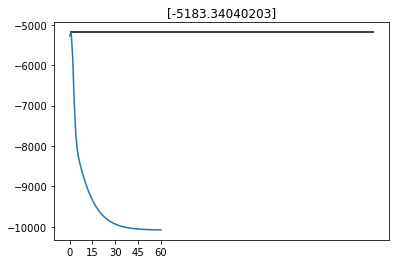

In [11]:
plt.plot(range(len(l)), l)
plt.hlines(best.log_likelihood(x01), 0, 200)
plt.title(best.log_likelihood(x01))

plt.xticks(np.arange(0, len(l), 15))

plt.show()

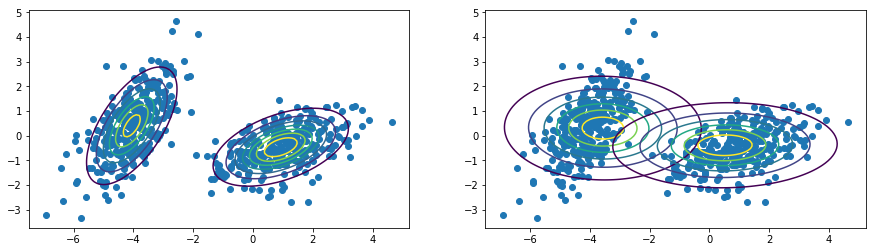

In [12]:
xmin, xmax = min(x01.T[0]), max(x01.T[0])
ymin, ymax = min(x01.T[1]), max(x01.T[1])

x, y = np.mgrid[xmin:xmax:.1, ymin:ymax:.1]
xy   = np.column_stack([x.ravel(), y.ravel()])

z = {}
for idx, mix in enumerate(t.mixes):
    z[idx] = mix.pdf(xy)

plt.figure(figsize=(15, 4))
    
plt.subplot(121)
plt.scatter(x01.T[0], x01.T[1])
for _ in z.values():
    plt.contour(x, y, np.reshape(_, x.shape))

z = {}
for idx, mix in enumerate(best.mixes):
    z[idx] = mix.pdf(xy)
plt.subplot(122)
plt.scatter(x01.T[0], x01.T[1])
for _ in z.values():
    plt.contour(x, y, np.reshape(_, x.shape))
    
plt.show()

In [39]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.scatter(x01.T[0], x01.T[1])

ims = []

for i in range(60):
    t.iterate(x01)
    
    z = {}
    for idx, mix in enumerate(t.mixes):
        z[idx] = mix.pdf(xy)

    im = ax.contour(x, y, np.reshape(z[0], x.shape))
    add_arts1 = im.collections
    
    im = ax.contour(x, y, np.reshape(z[1], x.shape))
    add_arts2 = im.collections

    an = ax.annotate(i, xy=(0.45, 1.05), xycoords='axes fraction')
    
    ims.append(add_arts1 + add_arts2 + [an])

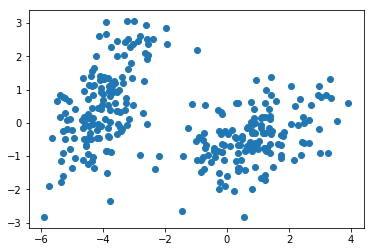

In [40]:
ani = ArtistAnimation(fig, ims)
ani.save('animation.gif', writer='imagemagick')

plt.show()